This file is where I produced my data after I increased the data size to include up to 8 vertices

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import pickle
import networkx as nx
import random as rand
import matplotlib.pyplot as plt
from qiskit import Aer, execute
from scipy.optimize import minimize
#way to visualize the graphs
def DrawGraph(Graph):
    plt.rcParams["figure.figsize"] = (10,6)
    pos=nx.spring_layout(Graph) 
    nx.draw_networkx(Graph,pos)
    labels = nx.get_edge_attributes(Graph,'weight')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=labels)
    plt.show()
    return 
#way to convert the graphs to a easy formatable manner
def matrix_to_edges(matrix):
    edges = []
    num_rows, num_cols = matrix.shape

    for row in range(num_rows):
        for col in range(row,num_cols):
            if matrix[row, col] != 0 and row!=col:
                edges.append((row, col))

    return edges

from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
def generate_binary_strings():
    binary_strings = []
    for i in range(256):
        binary_string = format(i, '08b')
        binary_strings.append(binary_string)
    return binary_strings
binary_strings = generate_binary_strings()
print(binary_strings)
#I pulled this from the data production to run the output back into qaoa to see how to distribution of the output compares to what was put inside.
def order_dictionary(dictionary):
    ordered_dict = {}
    sorted_keys = binary_strings  # Sort the keys in ascending order
    for key in sorted_keys:
        ordered_dict[key] = dictionary.get(key, 0)  # Add key-value pairs to the ordered dictionary
    dict_jdd = {}
    for i in range(128):
        dict_jdd[binary_strings[i]]=ordered_dict[binary_strings[i]] + ordered_dict[binary_strings[255-i]]
    return dict_jdd

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111', '00010000', '00010001', '00010010', '00010011', '00010100', '00010101', '00010110', '00010111', '00011000', '00011001', '00011010', '00011011', '00011100', '00011101', '00011110', '00011111', '00100000', '00100001', '00100010', '00100011', '00100100', '00100101', '00100110', '00100111', '00101000', '00101001', '00101010', '00101011', '00101100', '00101101', '00101110', '00101111', '00110000', '00110001', '00110010', '00110011', '00110100', '00110101', '00110110', '00110111', '00111000', '00111001', '00111010', '00111011', '00111100', '00111101', '00111110', '00111111', '01000000', '01000001', '01000010', '01000011', '01000100', '01000101', '01000110', '01000111', '01001000', '01001001', '01001010', '01001011', '01001100', '01001101', '01001110', '01001111', '01010000', '01010001', '01010010', '01

In [3]:

from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
         # problem unitary
        
            
    qc.measure_all()
        
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [2]:
def get_counts(graph):
    expectation = get_expectation(graph)
    res = minimize(expectation,[1,1],method='COBYLA')
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    from qiskit.visualization import plot_histogram
    qc_res = create_qaoa_circ(graph, res.x)
    #print(res.fun)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    counts = order_dictionary(counts)
    return counts
def CheckSol(graph1,graph2):
    #graph1 = model
    #graph2 = real
    check = matrix_to_edges(graph2)
    outy = matrix_to_edges(graph1)
    #to not get an error I need to iterate over the edges and produce the nodes
    graphcheck = nx.Graph()
    numbers = [num for edge in check for num in edge]
    max_number = max(numbers)
    number_list = list(range(max_number + 1))
    graphcheck.add_nodes_from(number_list)
    graphcheck.add_edges_from(check)
    graphouty = nx.Graph()
    numbers = [num for edge in outy for num in edge]
    max_number = max(numbers)
    number_list = list(range(max_number + 1))
    graphouty.add_nodes_from(number_list)
    graphouty.add_edges_from(outy)
    print("model prediction Graph:",graphouty.edges())
    DrawGraph(graphouty)
    print("Real Graph:",graphcheck.edges())
    DrawGraph(graphcheck)
    return [get_counts(graphouty),get_counts(graphcheck)] #Returns the prediction then the real

In [3]:
#here I am going to import the data that we set for the NN network
# Specify the file path of the pickle file
file_path = r'QAOACounts_16384_8_1P.pkl'

# Open the pickle file in binary mode and load the data using pickle.load()
with open(file_path, 'rb') as file:
    data_dict = pickle.load(file)

# Now you can use the loaded dictionary
print(len(data_dict['graphs']))
from torchvision import datasets, transforms
import itertools
array = torch.arange(12346)
# Get the size of the array
n = array.size(0)
# Generate a random permutation
torch.manual_seed(42)
perm = torch.randperm(n)
# Use the permutation to randomly organize the array
random_array = array[perm]

traina = []
vala=[]
valnums=[]
trainnums = []
valclock=0
#the values in range are supposed to indicate how much of the entire dataset do you want for training, I choose about 80%
for i in range(0,9877):
    traina.append([list(data_dict['counts'][random_array[i]].values())])
    traina[i].append(list(data_dict['graphs'][random_array[i]]))
    trainnums.append(i)
    #try to append it to the array : trainset[i].append
for i in range(9877,12346):
    vala.append([list(data_dict['counts'][random_array[i]].values())])
    vala[valclock].append(list(data_dict['graphs'][random_array[i]]))
    valnums.append(valclock)
    valclock+=1
trainset = torch.tensor(trainnums)
valset = torch.tensor(valnums)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=True)
#A batch size of 16 works really well, anything less may increase the accuracy by a small amount but takes alot longer.
print(len(traina))

12346
9877


The plain convolutional NN worked the best with this version of the model thus I delete all other versions and try to optimize it and understand what other errors occur.

In [5]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
#don't change the models depend on this structure
class HCNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(HCNet, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=8, stride=8)
        self.fc2 = nn.Linear(16, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=(8, 1), stride=(8, 1))
        self.fc3 = nn.Linear(16, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(32+128, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 96)
        self.bn5 = nn.BatchNorm1d(96)
        self.fc6 = nn.Linear(96, 64)
        self.tanh = nn.Tanh()
        nn.init.ones_(self.conv1.weight)
        nn.init.ones_(self.conv2.weight)


    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x1 = self.bn1(x1)
        x2 = F.relu(self.conv1(x.view(-1, 2, 64)))
        x2 = x2.view(x2.size(0), -1)
        x2 = F.relu(self.fc2(x2))
        x2 = self.bn2(x2)
        x3 = x.view(-1, 2, 8, 8)
        x3 = F.relu(self.conv2(x3))
        x3 = x3.view(x3.size(0), -1)
        x3 = F.relu(self.fc3(x3))
        x3 = self.bn3(x3)
        x4 = torch.cat((x1, x2, x3), dim=1)
        x4 = self.tanh(self.fc4(x4))
        x4 = self.bn4(x4)
        x4 = self.tanh(self.fc5(x4))
        x4 = self.bn5(x4)
        x4 = torch.sigmoid(self.fc6(x4))
        return x4
input_size = 128
output_size = 64

# Instantiate the model
hcnet = HCNet(input_size, output_size)
print(hcnet)



HCNet(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(2, 2, kernel_size=(8,), stride=(8,))
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(2, 2, kernel_size=(8, 1), stride=(8, 1))
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=160, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=128, out_features=96, bias=True)
  (bn5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=96, out_features=64, bias=True)
  (tanh): Tanh()
)


In [7]:
def train(model,optimizer,loss_fn,train_loader, val_loader,epochs,dataset):
    #time0 = time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)
    TotalAccuracy_graph = []
    GraphAccuracy_graph = []
    TotalAccuracy_graph_test = []
    GraphAccuracy_graph_test = []
    Epochnum = []
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        model.to(device)
        loss_fn.to(device)
        for ticks in train_loader:
            histo=[]
            gatrix=[]
            for i in range(0,len(ticks)):
                histo.append(traina[ticks[i]][0])
                gatrix.append(traina[ticks[i]][1])
            inputs = torch.squeeze(torch.tensor(histo), dim=1).to(device)
            target = torch.squeeze(torch.tensor(gatrix), dim=1).type(torch.FloatTensor).to(device)


        
            # Training pass
            optimizer.zero_grad()
            #inputs = inputs.requires_grad_()  # Enable gradient tracking
            output = model(inputs)
            output1 = (output > 0.5).float()
            correct = torch.eq(output1,target)
            output1 = torch.all(correct, dim=1, keepdim=True).view(-1)
            loss1 = loss_fn(output, target)
            output1 = torch.where(output1, torch.tensor(1), torch.tensor(0))
            loss2 = loss_fn(output1.float().to(device),torch.ones(output1.shape).float().to(device))
            
            loss=loss1+loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))
        test(model,optimizer,loss_fn, val_loader,dataset,False)
        ok = test(model,optimizer,loss_fn, valloader,vala,True)
        ok_test = test(model,optimizer,loss_fn, trainloader,traina,True)
        TotalAccuracy_graph.append(ok[0])
        GraphAccuracy_graph.append(ok[1])
        TotalAccuracy_graph_test.append(ok_test[0])
        GraphAccuracy_graph_test.append(ok_test[1])
        Epochnum.append(epoch)
    plt.plot(Epochnum,GraphAccuracy_graph,label="Graph Accuracy (Training)")
    plt.plot(Epochnum,GraphAccuracy_graph_test,label="Graph Accuracy (Testing)")
    plt.legend()
    plt.xlabel("epoch #")
    plt.ylabel("graph accuracy")
    plt.show()
#I kinda copied and pasted so of these so it may not look the best, but it works.
def test(model,optimizer,loss_fn, val_loader,dataset,shouldprint):
    #I started training utilizing my gpu, if you can not it will default to cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    num_correct =0
    num_examples =0
    num_correct_graphs=0
    num_examples_graphs=0
    model.to(device)
    for valticks in val_loader:
        valhisto=[]
        valgatrix=[]
        for i in range(0,len(valticks)):
            valhisto.append(dataset[valticks[i]][0])
            valgatrix.append(dataset[valticks[i]][1])
        inputs = (torch.squeeze(torch.tensor(valhisto), dim=1)).to(device)
        targets = (torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor)).to(device)
        output =(model(inputs) > 0.5).float().to(device) #makes sure the output is either 0 or 1 in the graphs
        loss = loss_fn(output,targets)
        correct = torch.eq(output,targets) #how many elements are correct 64 elements per graph
        correct_graphs = torch.all(correct, dim=1, keepdim=True).view(-1) # how much graphs are correct, much get all elements in graph to be true
        correct = torch.eq(output,targets).view(-1)
        num_correct +=torch.sum(correct).item() #adds up respective counts
        num_correct_graphs += torch.sum(correct_graphs).item()
        num_examples += correct.shape[0] #gets size
        num_examples_graphs += correct_graphs.shape[0]
        ok = [(num_correct) / (num_examples),(num_correct_graphs) / (num_examples_graphs),num_examples_graphs] # After the 
    if shouldprint:
        return ok
    else:
        print('accuracy for total elements: = {:.2f},accuracy for graphs: = {:.2f}, number of graphs: = {:.2f}'.format((num_correct) / (num_examples),(num_correct_graphs) / (num_examples_graphs),num_examples_graphs))
def testprint(model,optimizer,loss_fn, val_loader,num):
    device = "cpu"
    model.eval()
    model.to(device)
    valticks = next(iter(val_loader))
    valhisto=[]
    valgatrix=[]
    for i in range(0,len(valticks)):
        valhisto.append(vala[valticks[i]][0])
        valgatrix.append(vala[valticks[i]][1])
        #print(valticks[i])
    inputs = torch.squeeze(torch.tensor(valhisto), dim=1).to(device)
    targets = torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor).to(device)
    output =list(((model(inputs[num].unsqueeze(0)) > 0.5).float()).numpy())
    print("model graph:\n",np.array(output).reshape(8,8))
    #print(list(inputs[num]))
    print("Real Graph:\n",np.array(valgatrix[num]).reshape(8,8))
    print(np.array(valgatrix[num]).reshape(8,8)==np.array(output).reshape(8,8))
    return CheckSol(np.array(output).reshape(8,8),np.array(valgatrix[num]).reshape(8,8))
#--------------------
#--------------------
def testhist(model,optimizer,loss_fn, val_loader):#returns information about errors in the output
    device = "cpu"
    model.eval()
    model.to(device)
    total_correct = 0
    total_add =0
    total=0
    total_graph = 0
    #error_vertices_dict={}
    total_graph_incorrect = 0
    num_correct_graphs = 0
    total_subtract = 0
    check_vert_graph = np.zeros((8,8))
    error_graph_dict = {}
    for valticks in val_loader:
        valhisto=[]
        valgatrix=[]
        for i in range(0,len(valticks)):
            valhisto.append(vala[valticks[i]][0])
            valgatrix.append(vala[valticks[i]][1])
        inputs = torch.squeeze(torch.tensor(valhisto), dim=1).to(device)
        targets = torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor).to(device)
        for num in range(0,len(valticks)):
            total_graph+=1
            output =(model(inputs[num].unsqueeze(0)) > 0.5).float()
            correct = torch.eq(output,targets[num])
            correct_graphs = torch.all(correct)
            if correct_graphs.item():
                num_correct_graphs+=1
            output = list((output).numpy())
            check_matrix = (np.array(valgatrix[num]).reshape(8,8)-np.array(output).reshape(8,8))
            check_vert_graph+=abs(check_matrix)
            check_matrix = check_matrix.reshape(-1)
            for i in range(len(check_matrix)):
                total+=1
                if check_matrix[i]==0:
                    total_correct+=1
                elif check_matrix[i]==1:
                    total_add+=1
                elif check_matrix[i]==-1:
                    total_subtract+=1
            check_matrix = sum(abs(check_matrix))
            if check_matrix in error_graph_dict:
                error_graph_dict[check_matrix] += 1
            else:
                error_graph_dict[check_matrix] = 1
    total_graph_incorrect = total_graph - num_correct_graphs
    dictionary = {
    "total correct": total_correct/total,
    "total added": total_add/total,
    "total subtracted": total_subtract/total,
    "Error":(total_add+total_subtract)/total,
    "total":total,
    "avg. added": total_add/total_graph_incorrect,
    "avg. subtracted": total_subtract/total_graph_incorrect,
    "avg. error": (total_add+total_subtract)/total_graph_incorrect,
    "total incorrect": total_graph_incorrect
    }
    return dictionary,error_graph_dict,check_vert_graph

def GetTriangleAnalysis(model,optimizer,loss_fn, val_loader):#returns information about triangles in the graph, I utilize networkx triangles to get this information.
    # I urge you to lookup this function, it may result in triple counting.
    device = "cpu"
    model.eval()
    model.to(device)
    total_graph = 0
    Triangle_overview_dict = {"correct triangle":0,"incorrect predicted triangles":0,"incorrect real triangles":0}
    Triangle_disperse_dict ={}
    subtracted_disperse_method2_dict ={}
    added_disperse_method2_dict ={}
    subtracted_disperse_method3_dict ={}
    added_disperse_method3_dict ={}
    subtracted_disperse_method1_dict ={}
    added_disperse_method1_dict ={}

    #error_vertices_dict={}
    for valticks in val_loader:
        valhisto=[]
        valgatrix=[]
        for i in range(0,len(valticks)):
            valhisto.append(vala[valticks[i]][0])
            valgatrix.append(vala[valticks[i]][1])
        inputs = torch.squeeze(torch.tensor(valhisto), dim=1).to(device)
        targets = torch.squeeze(torch.tensor(valgatrix), dim=1).type(torch.FloatTensor).to(device)
        for num in range(0,len(valticks)):
            total_graph+=1
            output =(model(inputs[num].unsqueeze(0)) > 0.5).float()
            correct = torch.eq(output,targets[num])
            correct_graphs = torch.all(correct)
            output_edge = matrix_to_edges(output.reshape(8,8))
            graphoutput = nx.Graph()
            numbers = [num for edge in output_edge for num in edge]
            max_number = max(numbers)
            number_list = list(range(max_number + 1))
            graphoutput.add_nodes_from(number_list)
            graphoutput.add_edges_from(output_edge)
            target_edge = matrix_to_edges(targets[num].reshape(8,8))
            graphtarget = nx.Graph()
            numbers = [num for edge in target_edge for num in edge]
            max_number = max(numbers)
            number_list = list(range(max_number + 1))
            graphtarget.add_nodes_from(number_list)
            graphtarget.add_edges_from(target_edge)
            if correct_graphs.item():
                my_dict1 = nx.triangles(graphoutput)
                for value in my_dict1.values():
                    Triangle_overview_dict["correct triangle"] += value
            else:
                my_dict1 = nx.triangles(graphoutput)
                my_dict2 = nx.triangles(graphtarget)
                count1 = 0
                count2 = 0
                for value in my_dict1.values():
                    count1 +=value
                Triangle_overview_dict["incorrect predicted triangles"] += count1
                for value in my_dict2.values():
                    count2 += value
                Triangle_overview_dict["incorrect real triangles"] += count2
                count_total = count1-count2
                if count_total in Triangle_disperse_dict:
                    Triangle_disperse_dict[count_total] += 1
                else:
                    Triangle_disperse_dict[count_total] = 1
            #matrix_to_edges
                check_matrix1= abs(np.array(valgatrix[num]).reshape(8,8)-np.array(output).reshape(8,8))
                check_edges = matrix_to_edges(check_matrix1)
                #-------method 3 -------------------look at traingles of edges of full graph no modifications
                for i in range(len(check_edges)):
                    if check_edges[i] in target_edge: #it is subtracted
                        my_count = 0
                        my_dict1 = nx.triangles(graphoutput,(check_edges[i][0],check_edges[i][1]))
                        my_dict2 = nx.triangles(graphtarget,(check_edges[i][0],check_edges[i][1]))
                        my_count = (my_dict1[check_edges[i][0]] + my_dict1[check_edges[i][1]] - my_dict2[check_edges[i][0]] - my_dict2[check_edges[i][1]])
                        #print(my_count)
                        if check_edges[i] in subtracted_disperse_method3_dict:
                            subtracted_disperse_method3_dict[check_edges[i]] -= my_count
                        else:
                            subtracted_disperse_method3_dict[check_edges[i]] = my_count
                    else: #added
                        my_count = 0
                        my_dict1 = nx.triangles(graphoutput,(check_edges[i][0],check_edges[i][1]))
                        my_dict2 = nx.triangles(graphtarget,(check_edges[i][0],check_edges[i][1]))
                        my_count = (my_dict1[check_edges[i][0]] + my_dict1[check_edges[i][1]] - my_dict2[check_edges[i][0]] - my_dict2[check_edges[i][1]])
                        #print(my_count)
                        if check_edges[i] in added_disperse_method3_dict:
                            added_disperse_method3_dict[check_edges[i]] += my_count
                        else:
                            added_disperse_method3_dict[check_edges[i]] = my_count
                #-------------------------------------------------
                #---------------method 2 ----------------------
                #This method I aim to separate the errors into two graphs: subtracted and added. Then I shall compare this to the orginal, coutning the total # of triangles associated
                #with the added or subtracted traingles. This method Dr. Ostrowski thought of.
                target_edge = matrix_to_edges(targets[num].reshape(8,8))
                graphtarget = nx.Graph()
                numbers = [num for edge in target_edge for num in edge]
                max_number = max(numbers)
                number_list = list(range(max_number + 1))
                graphtarget.add_nodes_from(number_list)
                graphtarget.add_edges_from(target_edge)
                graphoutput_method2_addition = nx.Graph()
                graphoutput_method2_subtraction = nx.Graph()
                check_edges_method2_subtraction = target_edge
                target_edge = matrix_to_edges(targets[num].reshape(8,8))
            
                for i in range(len(check_edges)):
                    if check_edges[i] in target_edge:
                        #if in target_edge then that means it was subtracted
                        #then we do nothing
                        check_edges_method2_subtraction.remove(check_edges[i])
                
                numbers = [num for edge in check_edges_method2_subtraction for num in edge]
                max_number = max(numbers)
                number_list = list(range(max_number + 1))
                graphoutput_method2_subtraction.add_nodes_from(number_list)
                graphoutput_method2_subtraction.add_edges_from(check_edges_method2_subtraction)

                for i in range(len(check_edges)):
                    if check_edges[i] in target_edge: #it is subtracted
                        my_count = 0
                        my_dict1 = nx.triangles(graphoutput_method2_subtraction,(check_edges[i]))
                        my_dict2 = nx.triangles(graphtarget,(check_edges[i]))
                        my_count = (min(my_dict1.values()) - min(my_dict2.values()))
                        if(my_count>0):
                            print("target:", target_edge)
                            print("check edges",check_edges)
                            print("sub:",check_edges_method2_subtraction)
                        if check_edges[i] in subtracted_disperse_method2_dict:
                            subtracted_disperse_method2_dict[check_edges[i]] -= my_count
                        else:
                            subtracted_disperse_method2_dict[check_edges[i]] = my_count


                            #-------------------------------------
                #method 1: I aim to look at every error in a graph in a isolated incidence such that if I have a graph of 10 error then I produce 10 graphs that I shall compare
                # to the orignal looking at the toal amount of triangle added or subtracted associated with the change.
                what_edges = matrix_to_edges(targets[num].reshape(8,8))
                graphtarget = nx.Graph()
                numbers = [num for edge in what_edges for num in edge]
                max_number = max(numbers)
                number_list = list(range(max_number + 1))
                graphtarget.add_nodes_from(number_list)
                graphtarget.add_edges_from(what_edges)
                graphoutput_method2_addition = nx.Graph()
                check_edges_method2_addition = what_edges
                #print(1)
                for i in range(len(check_edges)):
                    if check_edges[i] not in what_edges:
                        check_edges_method2_addition.append(check_edges[i])

                numbers = [num for edge in check_edges_method2_addition for num in edge]
                max_number = max(numbers)
                number_list = list(range(max_number + 1))
                graphoutput_method2_addition.add_nodes_from(number_list)
                graphoutput_method2_addition.add_edges_from(check_edges_method2_addition)
                for i in range(len(check_edges)):
                    if check_edges[i] in what_edges:
                        my_count = 0
                        my_dict1 = nx.triangles(graphoutput_method2_addition,(check_edges[i][0],check_edges[i][1]))
                        my_dict2 = nx.triangles(graphtarget,(check_edges[i][0],check_edges[i][1]))
                        my_count = (min(my_dict1.values()) - min(my_dict2.values()))
                        #print(my_count)
                        
                        if(my_count<0):
                            print("target:", what_edges)
                            print("check edges",check_edges)
                            print("sub:",check_edges_method2_addition)
                            print(my_count)
                        if check_edges[i] in added_disperse_method2_dict:
                            added_disperse_method2_dict[check_edges[i]] += my_count
                        else:
                            added_disperse_method2_dict[check_edges[i]] = my_count
                #---------------------------------------
                for i in range(len(check_edges)):
                    target_edge = matrix_to_edges(targets[num].reshape(8,8))
                    graphtarget = nx.Graph()
                    numbers = [num for edge in target_edge for num in edge]
                    max_number = max(numbers)
                    number_list = list(range(max_number + 1))
                    graphtarget.add_nodes_from(number_list)
                    graphtarget.add_edges_from(target_edge)
                    graphoutput_method1 = nx.Graph()
                    check_edges_method1 = target_edge
                    # print("target",target_edge)
                    # print(check_edges[i])
                    if check_edges[i] in target_edge:
                        check_edges_method1.remove(check_edges[i])
                        numbers = [num for edge in check_edges_method1 for num in edge]
                        max_number = max(numbers)
                        number_list = list(range(max_number + 1))
                        graphoutput_method1.add_nodes_from(number_list)
                        graphoutput_method1.add_edges_from(check_edges_method1)
                        my_count = 0
                        my_dict1 = nx.triangles(graphoutput_method1,(check_edges[i][0],check_edges[i][1]))
                        my_dict2 = nx.triangles(graphtarget,(check_edges[i][0],check_edges[i][1]))
                        my_count = (min(my_dict1.values()) - min(my_dict2.values()))
                        #print(my_count)
                        if check_edges[i] in subtracted_disperse_method1_dict:
                            subtracted_disperse_method1_dict[check_edges[i]] -= my_count
                        else:
                            subtracted_disperse_method1_dict[check_edges[i]] = my_count
                        # print("sub")
                        # print(check_edges_method1)
                    else:
                        check_edges_method1.append(check_edges[i])
                        numbers = [num for edge in check_edges_method1 for num in edge]
                        max_number = max(numbers)
                        number_list = list(range(max_number + 1))
                        graphoutput_method1.add_nodes_from(number_list)
                        graphoutput_method1.add_edges_from(check_edges_method1)
                        my_count = 0
                        my_dict1 = nx.triangles(graphoutput_method1,(check_edges[i][0],check_edges[i][1]))
                        my_dict2 = nx.triangles(graphtarget,(check_edges[i][0],check_edges[i][1]))
                        my_count = (min(my_dict1.values()) - min(my_dict2.values()))
                        if check_edges[i] in added_disperse_method1_dict:
                            added_disperse_method1_dict[check_edges[i]] += my_count
                        else:
                            added_disperse_method1_dict[check_edges[i]] = my_count
                #-----------------method 1--------------------


    return Triangle_overview_dict, Triangle_disperse_dict, added_disperse_method3_dict, subtracted_disperse_method3_dict, added_disperse_method2_dict,subtracted_disperse_method2_dict,added_disperse_method1_dict,subtracted_disperse_method1_dict

example of how to use GetTraingleAnalysis. Method 2 from GetTriangleAnalysis works best so I urge you to use that for analysis if you do. I kept everything else in for transparency. I am bad at coming up with names so don't judge.  

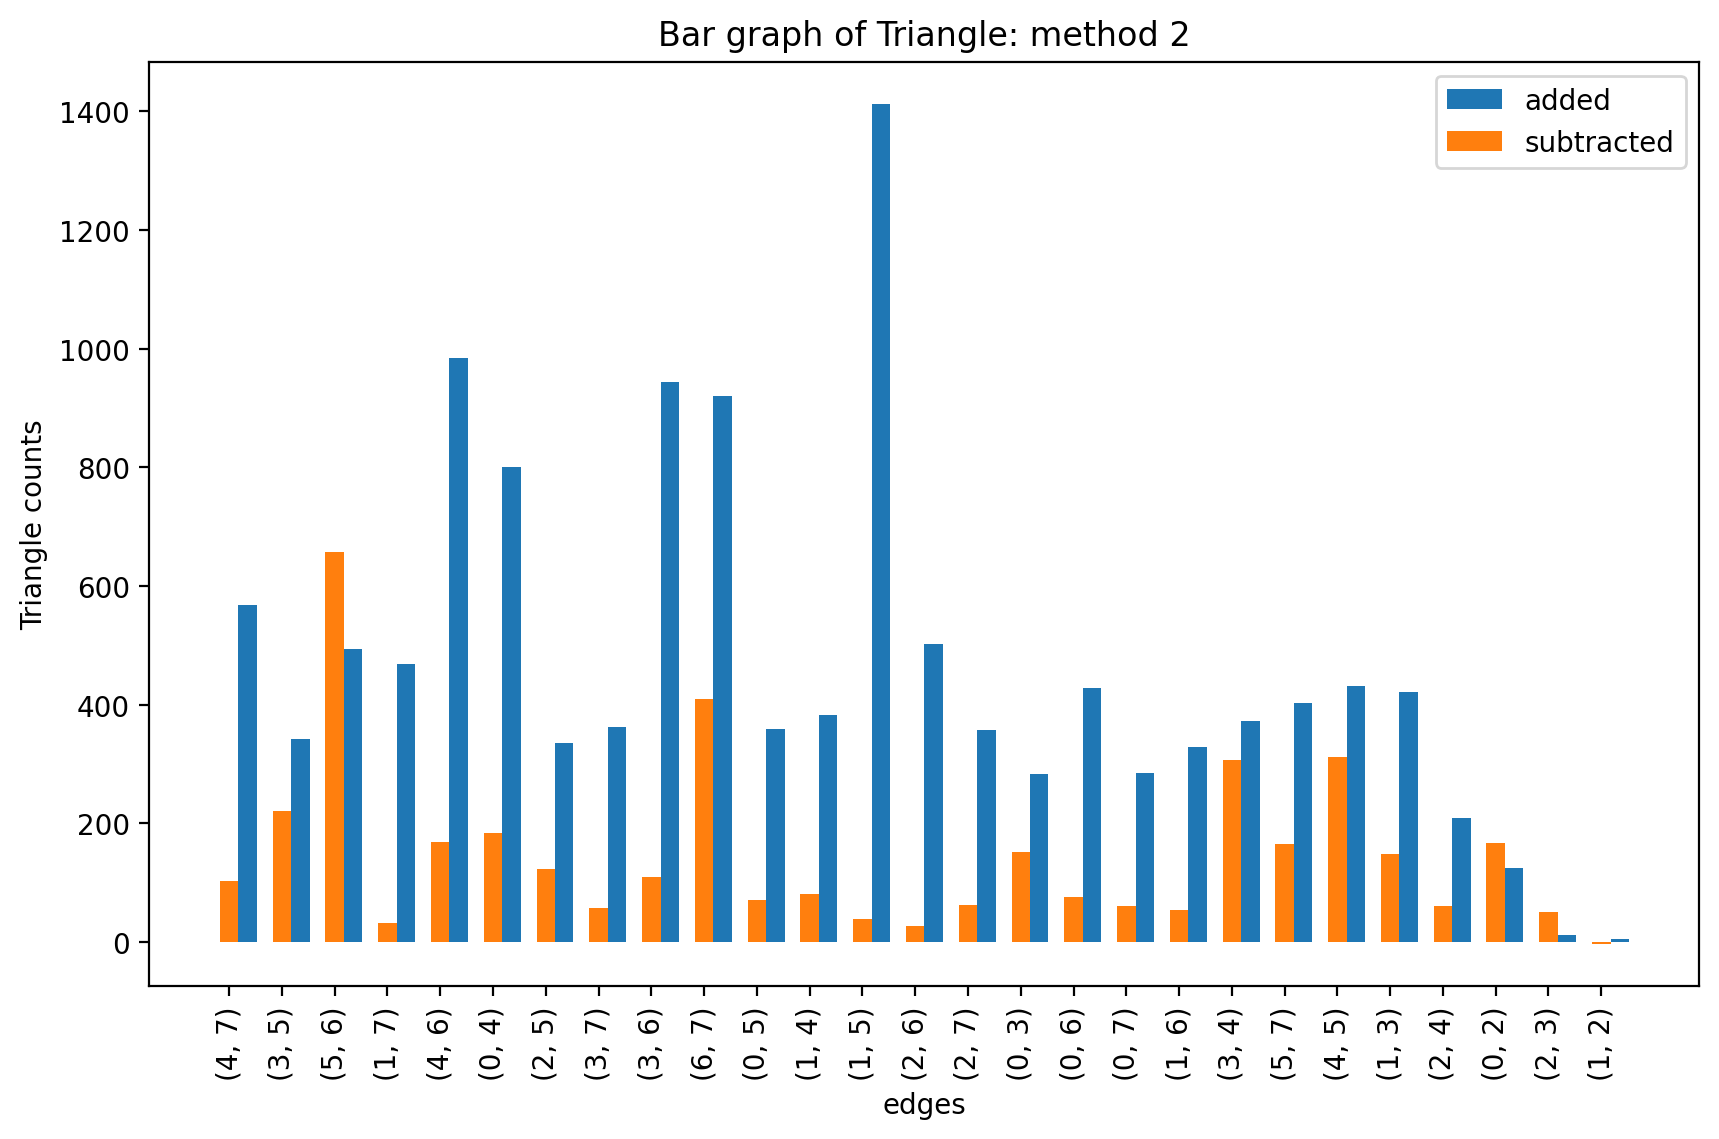

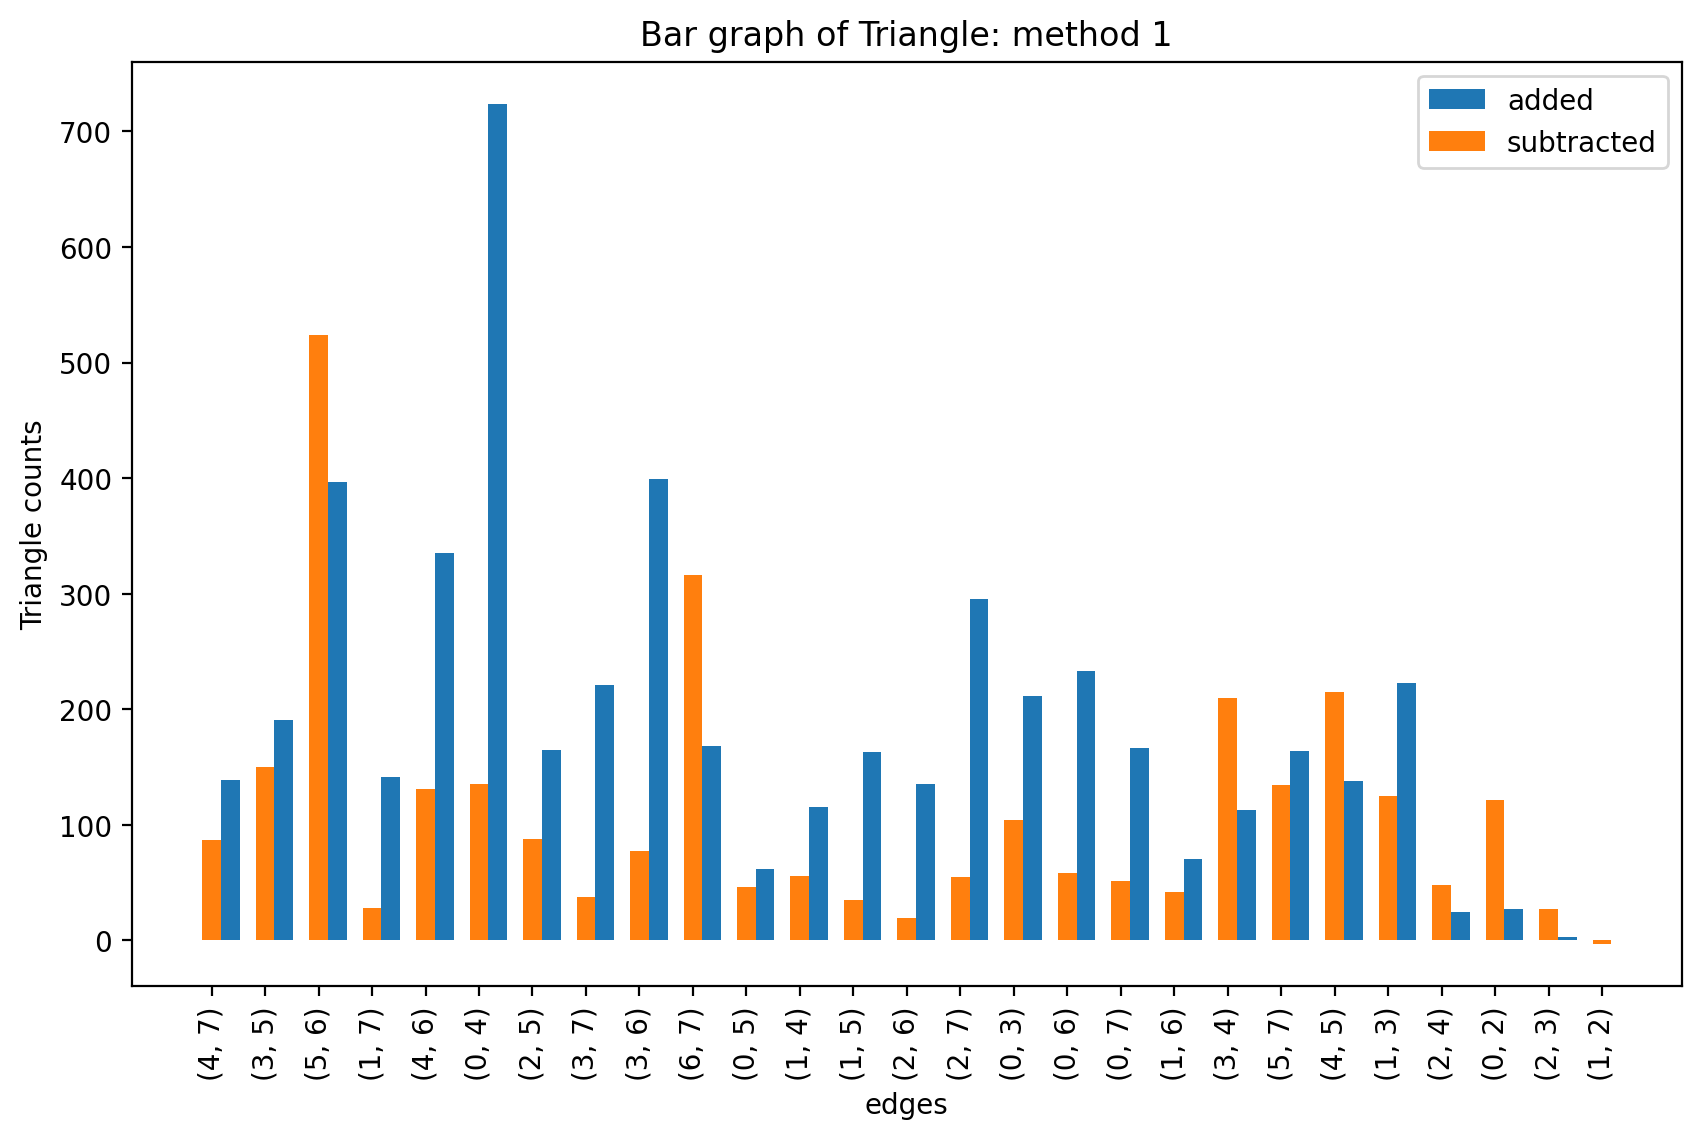

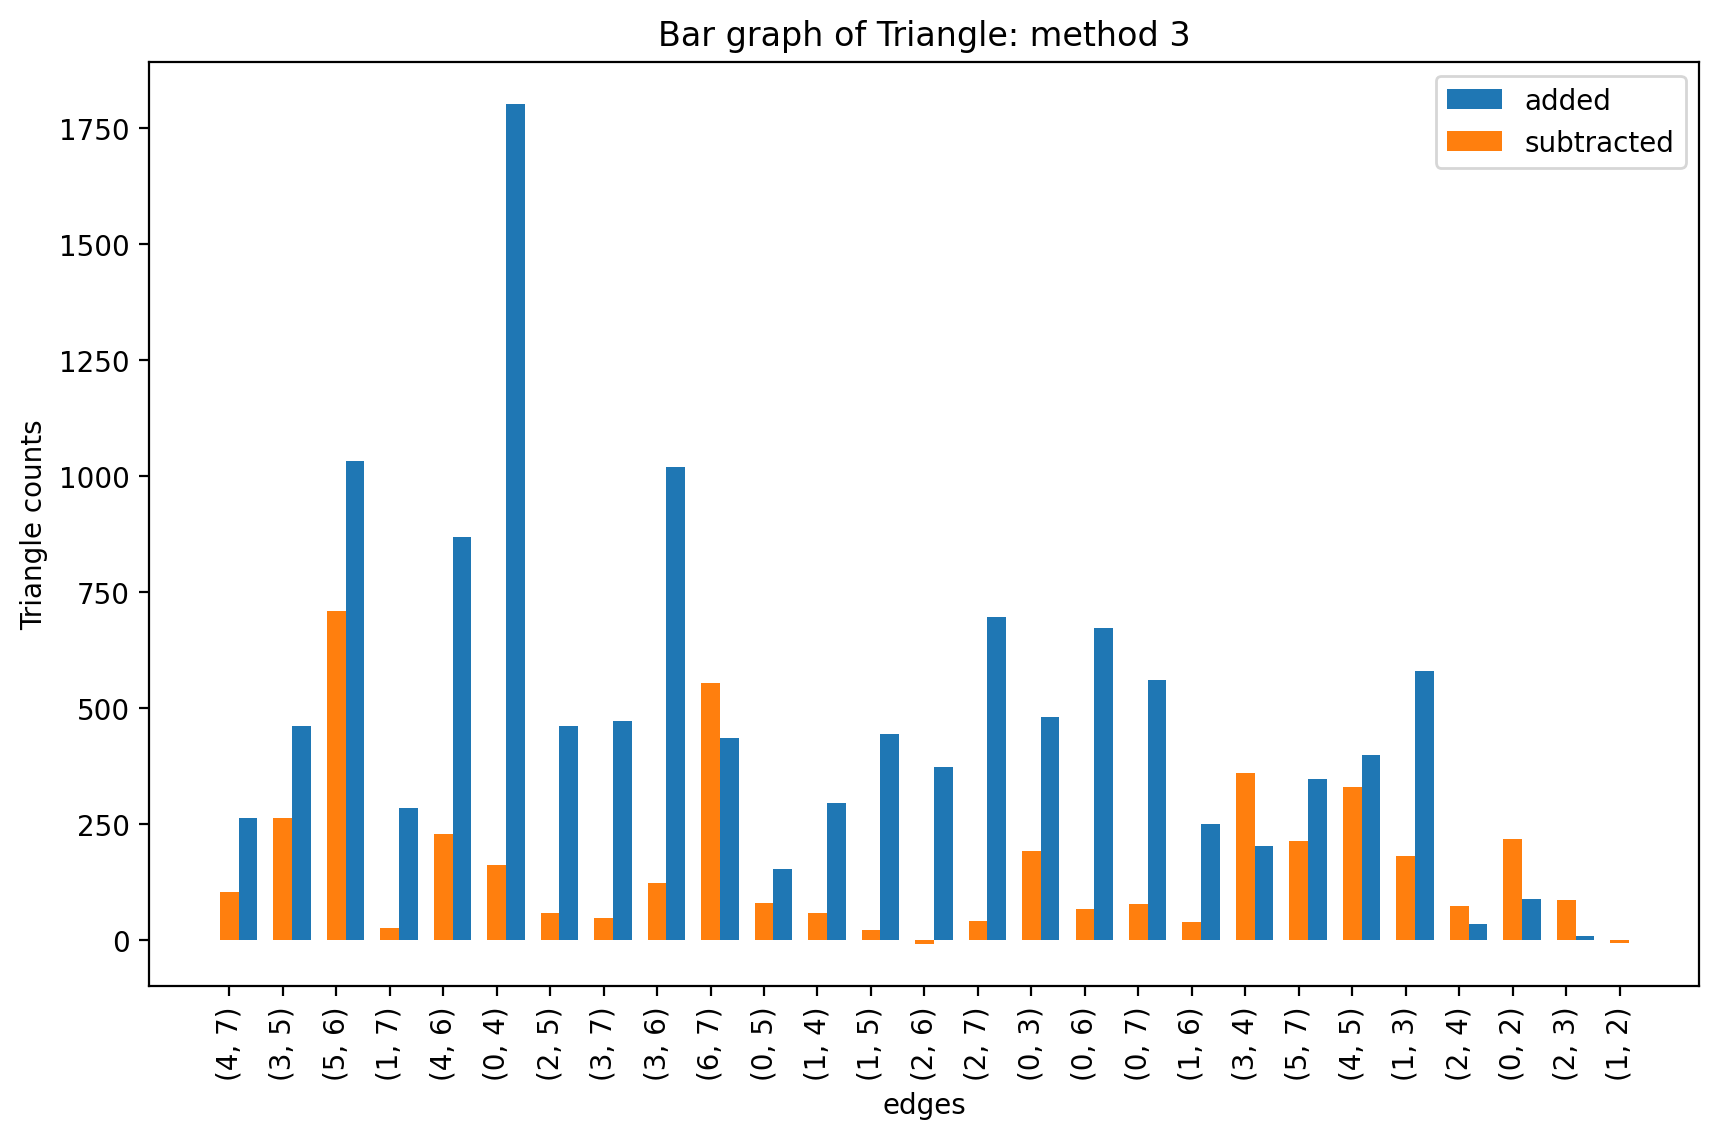

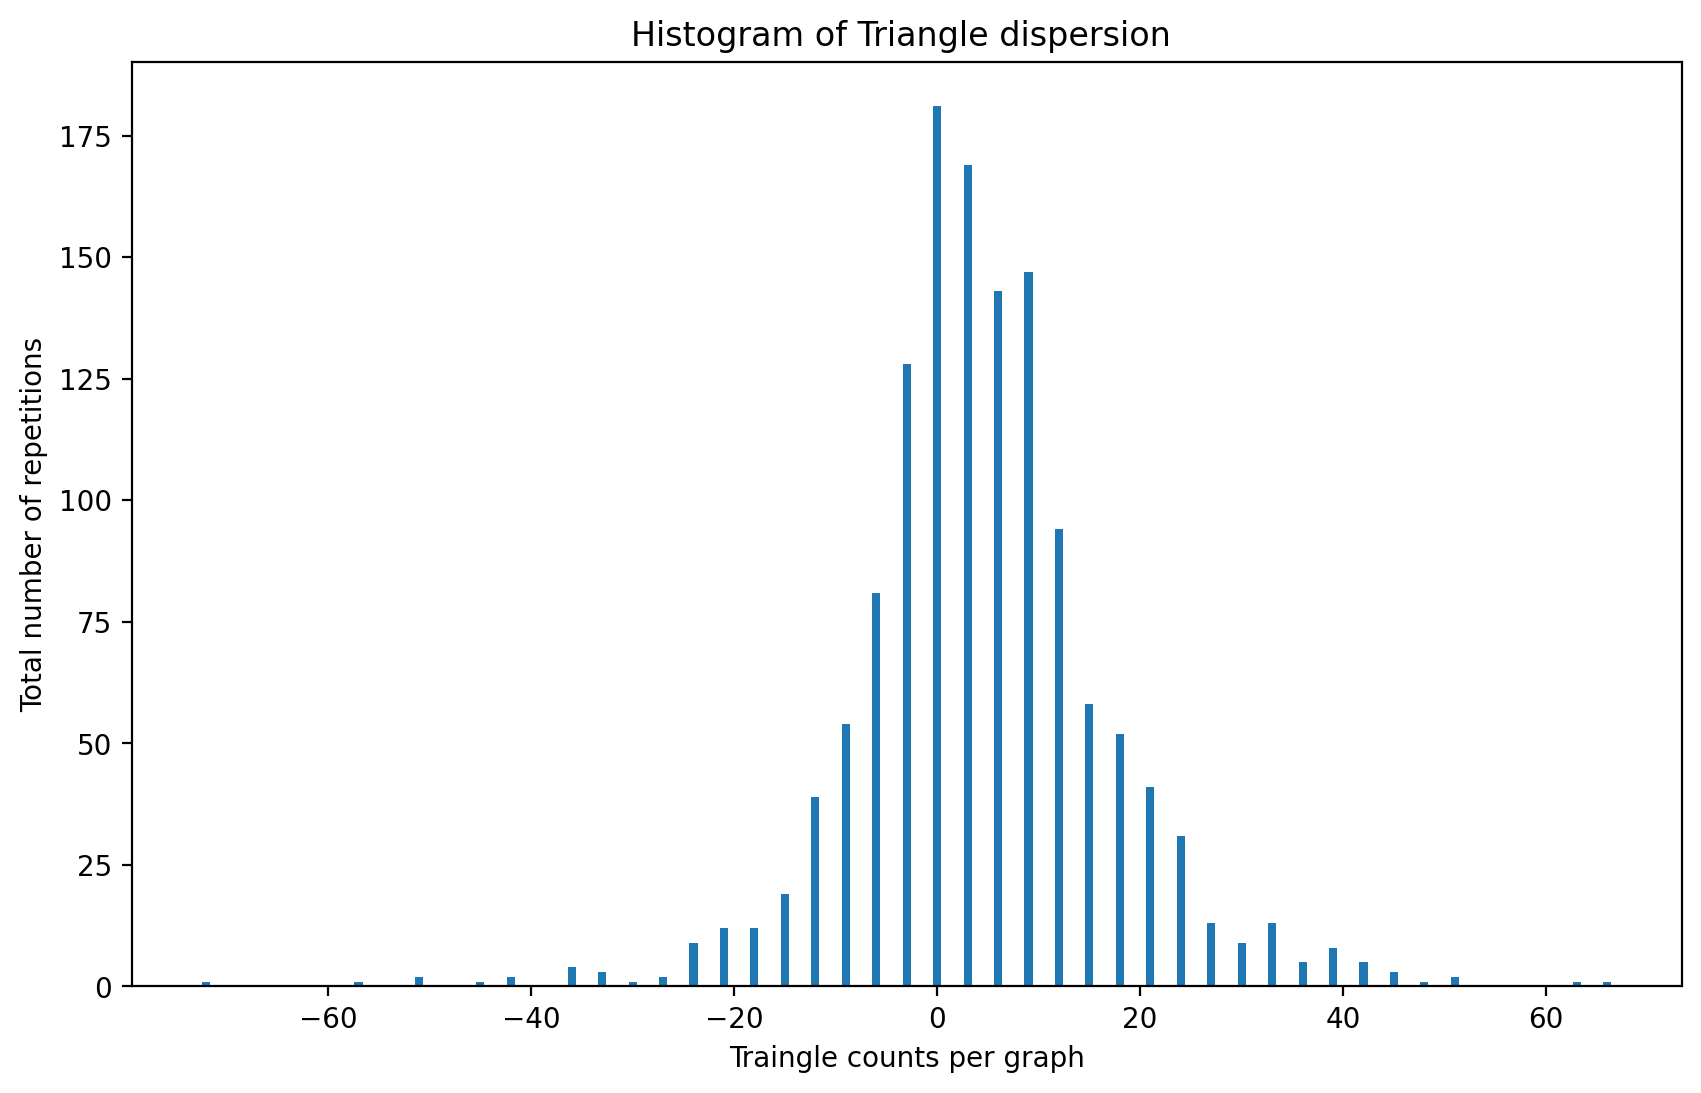

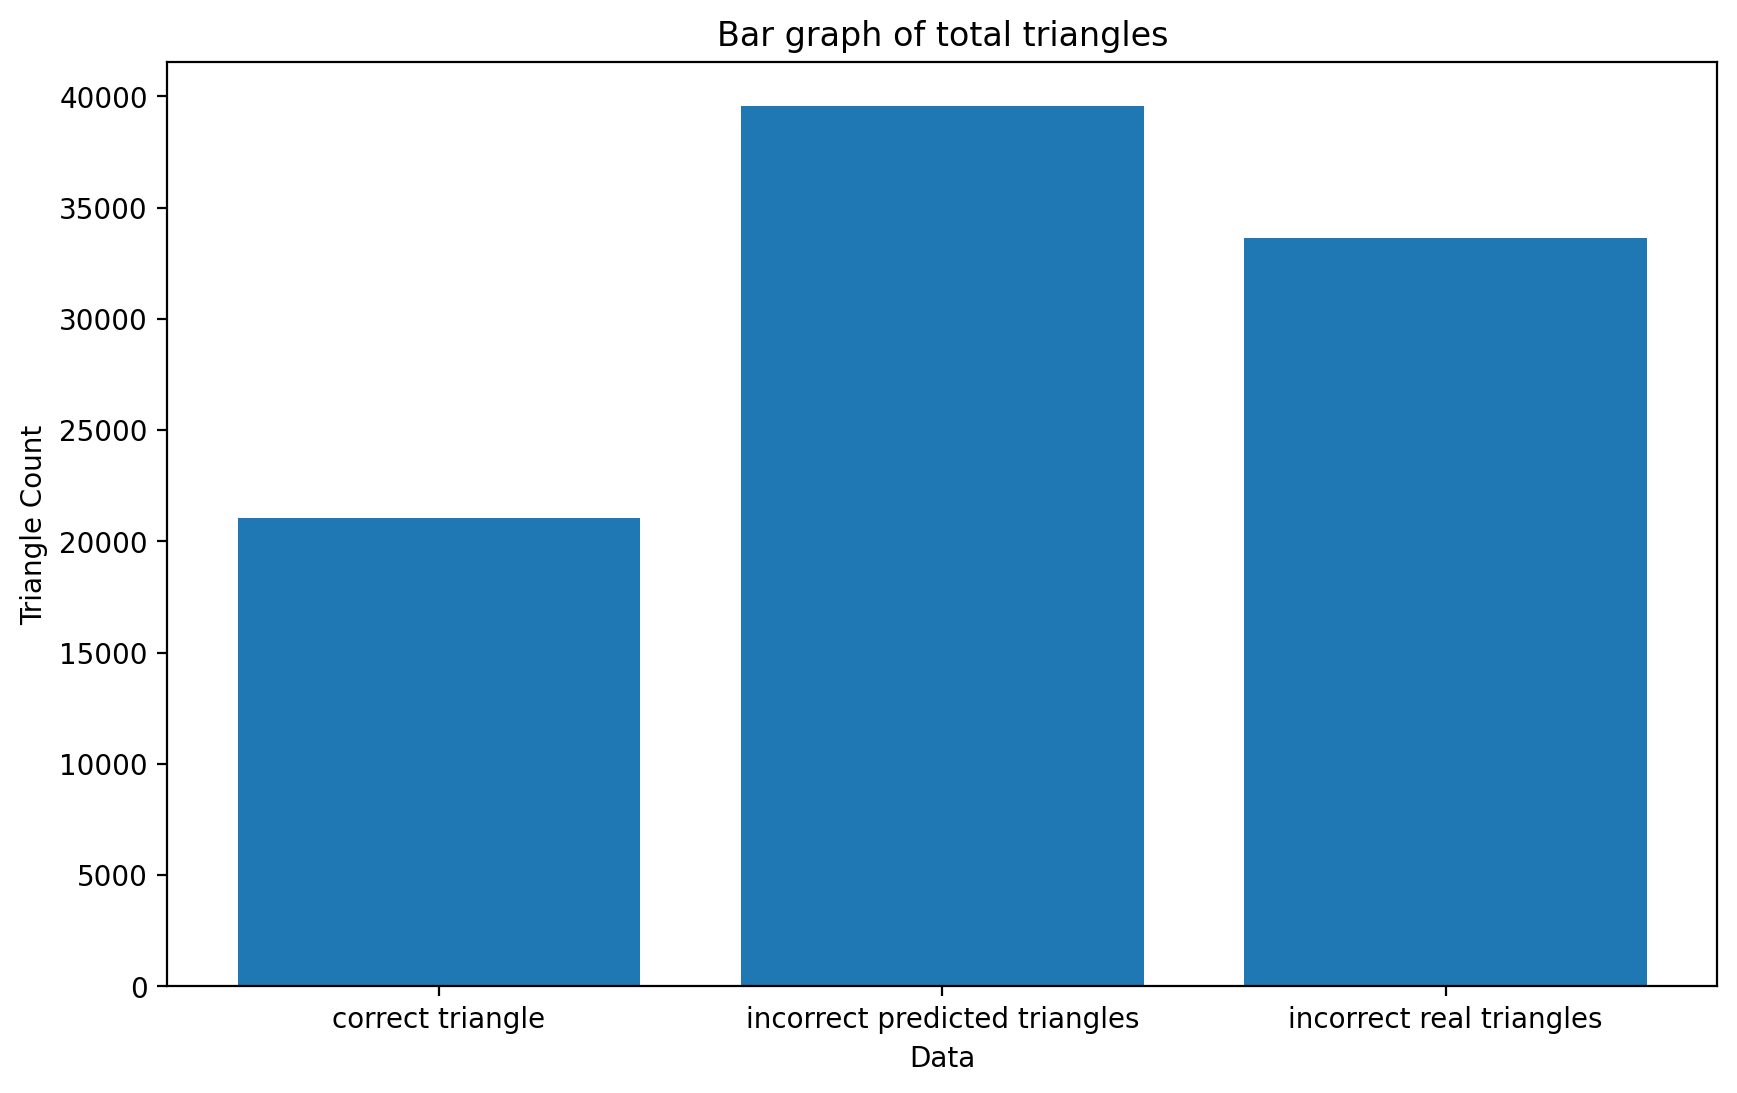

In [245]:
overview,disperse,addmethod3,submethod3,dict6,dict5, addmethod1,submethod1= GetTriangleAnalysis(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader)
labels1 = dict6.keys()
labels1 = [str(x) for x in labels1]
values1 = dict6.values()
labels2 = dict5.keys()
labels2 = [str(x) for x in labels2]
values2 = dict5.values()
x_pos = np.arange(len(labels1))
bar_width = 0.35
x_pos_shifted = x_pos + bar_width
plt.bar(x_pos_shifted,values1, width=bar_width,label="added")
plt.bar(labels2,values2, width=bar_width,label="subtracted")
x_pos_shifted = x_pos + bar_width
#plt.xticks(x_pos_shifted, labels2)
plt.xticks(rotation='vertical')
# # Add labels and title
plt.xlabel('edges')
plt.ylabel('Triangle counts')
plt.title(f'Bar graph of Triangle: method 2')
plt.legend()
plt.show()
#------------------------
labels1 = addmethod1.keys()
labels1 = [str(x) for x in labels1]
values1 = addmethod1.values()
labels2 = submethod1.keys()
labels2 = [str(x) for x in labels2]
values2 = submethod1.values()
x_pos = np.arange(len(labels1))
bar_width = 0.35
x_pos_shifted = x_pos + bar_width
plt.bar(x_pos_shifted,values1, width=bar_width,label="added")
plt.bar(labels2,values2, width=bar_width,label="subtracted")
x_pos_shifted = x_pos + bar_width
#plt.xticks(x_pos_shifted, labels1)
plt.xticks(rotation='vertical')
# # Add labels and title
plt.xlabel('edges')
plt.ylabel('Triangle counts')
plt.title(f'Bar graph of Triangle: method 1')
plt.legend()
plt.show()

#-----------------------------
labels1 = addmethod3.keys()
labels1 = [str(x) for x in labels1]
values1 = addmethod3.values()
labels2 = submethod3.keys()
labels2 = [str(x) for x in labels2]
values2 = submethod3.values()
x_pos = np.arange(len(labels1))
bar_width = 0.35
x_pos_shifted = x_pos + bar_width
plt.bar(x_pos_shifted,values1, width=bar_width,label="added")
plt.bar(labels2,values2, width=bar_width,label="subtracted")
x_pos_shifted = x_pos + bar_width
#plt.xticks(x_pos_shifted, labels1)
plt.xticks(rotation='vertical')
# # Add labels and title
plt.xlabel('edges')
plt.ylabel('Triangle counts')
plt.title(f'Bar graph of Triangle: method 3')
plt.legend()
plt.show()
#---------------------disperse----------------------
labels = disperse.keys()
values = disperse.values()
plt.bar(labels,values)
plt.title(f'Histogram of Triangle dispersion ')
plt.xlabel('Traingle counts per graph')
plt.ylabel('Total number of repetitions')
plt.show()
#------------------overview ----------------
labels = overview.keys()
values = overview.values()
plt.title('Bar graph of total triangles')
plt.xlabel('Data')
plt.ylabel('Triangle Count')
plt.bar(labels,values)
plt.show()

Below I try to modifiy the network I had above by adding more layers based off of symmetries in the distributions. Does not work as well.

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

class HCNet3(nn.Module):
    def __init__(self, input_size, output_size):
        super(HCNet3, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=8, stride=8)
        self.conv3 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=16, stride=8)
        self.fc2 = nn.Linear(16, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=(8, 1), stride=(8, 1))
        self.fc3 = nn.Linear(16, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(32, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 32)
        self.tanh = nn.Tanh()
        nn.init.ones_(self.conv1.weight)
        nn.init.ones_(self.conv2.weight)
        self.max_pool_layer = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc7 = nn.Linear(64, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc8 = nn.Linear(128, 128)
        self.fc9 = nn.Linear(16, 16)
        self.bn7 = nn.BatchNorm1d(32)
        self.bn8 = nn.BatchNorm1d(32)
        self.fc10 = nn.Linear(128+32+22, 128)
        self.fc11 = nn.Linear(128, 64)
        #-------------
        self.conv8_1=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor1 = torch.zeros(1, 1, 128)
        weight_tensor1[0, 0, 0] = 1
        self.conv8_1.weight =nn.Parameter(weight_tensor1)
        self.conv8_2=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor2 = torch.zeros(1, 1, 128)
        weight_tensor2[0, 0, 1] = 1
        self.conv8_2.weight =nn.Parameter(weight_tensor2)
        self.conv8_3=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor3 = torch.zeros(1, 1, 128)
        weight_tensor3[0, 0, 3] = 1
        self.conv8_3.weight =nn.Parameter(weight_tensor3)
        self.conv8_4=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor4 = torch.zeros(1, 1, 128)
        weight_tensor4[0, 0, 7] = 1
        self.conv8_4.weight =nn.Parameter(weight_tensor4)
        self.conv8_5=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor5 = torch.zeros(1, 1, 128)
        weight_tensor5[0, 0, 15] = 1
        self.conv8_5.weight =nn.Parameter(weight_tensor5)
        self.conv8_6=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor6 = torch.zeros(1, 1, 128)
        weight_tensor6[0, 0, 31] = 1
        self.conv8_6.weight =nn.Parameter(weight_tensor6)
        self.conv8_7=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7 = torch.zeros(1, 1, 128)
        weight_tensor7[0, 0, 63] = 1
        self.conv8_7.weight =nn.Parameter(weight_tensor7)
        self.conv8_8=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor8 = torch.zeros(1, 1, 128)
        weight_tensor8[0, 0, 127] = 1
        self.conv8_8.weight =nn.Parameter(weight_tensor8)
        self.conv8_9=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor9 = torch.zeros(1, 1, 128)
        weight_tensor9[0, 0, 125] = 1
        self.conv8_9.weight =nn.Parameter(weight_tensor9)
        self.conv8_10=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor10 = torch.zeros(1, 1, 128)
        weight_tensor10[0, 0, 124] = 1
        self.conv8_10.weight =nn.Parameter(weight_tensor10)
        self.conv8_11=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor11 = torch.zeros(1, 1, 128)
        weight_tensor11[0, 0, 122] = 1
        self.conv8_11.weight =nn.Parameter(weight_tensor11)
        self.conv8_12=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor12 = torch.zeros(1, 1, 128)
        weight_tensor12[0, 0, 118] = 1
        self.conv8_12.weight =nn.Parameter(weight_tensor12)
        self.conv8_13=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor13 = torch.zeros(1, 1, 128)
        weight_tensor13[0, 0, 110] = 1
        self.conv8_13.weight =nn.Parameter(weight_tensor13)
        self.conv8_14=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor14 = torch.zeros(1, 1, 128)
        weight_tensor14[0, 0, 94] = 1
        self.conv8_14.weight =nn.Parameter(weight_tensor14)
        self.conv8_15=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor15 = torch.zeros(1, 1, 128)
        weight_tensor15[0, 0, 62] = 1
        self.conv8_15.weight =nn.Parameter(weight_tensor15)
        self.fc8_1 = nn.Linear(22,22)
        self.bn8_1 = nn.BatchNorm1d(22)
        #-----------
        self.conv7_1=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_1 = torch.zeros(1, 1, 128)
        weight_tensor7_1[0, 0, 62] = 1
        self.conv7_1.weight =nn.Parameter(weight_tensor7_1)
        self.conv7_2=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_2 = torch.zeros(1, 1, 128)
        weight_tensor7_2[0, 0, 29] = 1
        self.conv7_2.weight =nn.Parameter(weight_tensor7_2)
        self.conv7_3=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_3 = torch.zeros(1, 1, 128)
        weight_tensor7_3[0, 0, 46] = 1
        self.conv7_3.weight =nn.Parameter(weight_tensor7_3)
        self.conv7_4=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_4 = torch.zeros(1, 1, 128)
        weight_tensor7_4[0, 0, 54] = 1
        self.conv7_4.weight =nn.Parameter(weight_tensor7_4)
        self.conv7_5=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_5 = torch.zeros(1, 1, 128)
        weight_tensor7_5[0, 0, 58] = 1
        self.conv7_5.weight =nn.Parameter(weight_tensor7_5)
        self.conv7_6=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_6 = torch.zeros(1, 1, 128)
        weight_tensor7_6[0, 0, 60] = 1
        self.conv7_6.weight =nn.Parameter(weight_tensor7_6)
        self.conv7_7=nn.Conv1d(1,1,kernel_size=128,stride=1)
        weight_tensor7_7 = torch.zeros(1, 1, 128)
        weight_tensor7_7[0, 0, 61] = 1
        self.conv7_7.weight =nn.Parameter(weight_tensor7_7)

        #----------------
    def forward(self, x):
        #-----------------
        x8_1 =self.conv8_1(x.view(-1, 1, 128))
        x8_2 = self.conv8_2(x.view(-1, 1, 128))
        x8_3 = self.conv8_3(x.view(-1, 1, 128))
        x8_4 = self.conv8_4(x.view(-1, 1, 128))
        x8_5 = self.conv8_5(x.view(-1, 1, 128))
        x8_6 = self.conv8_6(x.view(-1, 1, 128))
        x8_7 = self.conv8_7(x.view(-1, 1, 128))
        x8_8 = self.conv8_8(x.view(-1, 1, 128))
        x8_9 = self.conv8_9(x.view(-1, 1, 128))
        x8_10 = self.conv8_10(x.view(-1, 1, 128))
        x8_11= self.conv8_11(x.view(-1, 1, 128))
        x8_12 =self.conv8_12(x.view(-1, 1, 128))
        x8_13 = self.conv8_13(x.view(-1, 1, 128))
        x8_14 = self.conv8_14(x.view(-1, 1, 128))
        x8_15 = self.conv8_15(x.view(-1, 1, 128))
        x7_1 = self.conv7_1(x.view(-1, 1, 128))
        x7_2 = self.conv7_2(x.view(-1, 1, 128))
        x7_3 = self.conv7_3(x.view(-1, 1, 128))
        x7_4 = self.conv7_4(x.view(-1, 1, 128))
        x7_5 = self.conv7_5(x.view(-1, 1, 128))
        x7_6 = self.conv7_6(x.view(-1, 1, 128))
        x7_7 = self.conv7_7(x.view(-1, 1, 128))
        x8_15 = torch.cat((x8_1,x8_2,x8_3,x8_4,x8_5,x8_6,x8_7,x8_8,x8_9,x8_10,x8_11,x8_12,x8_13,x8_14,x8_15,x7_1,x7_2,x7_3,x7_4,x7_5,x7_6,x7_7),dim=1).view(-1,1,22)
        x8_15 = x8_15.view(x8_15.size(0),-1)
        x8_15 = F.relu(self.bn8_1((self.fc8_1(x8_15))))
        #print(x8_15.shape)
        #--------------------
        x1 = self.fc1(x)
        x1 = F.relu(self.bn1(x1))
        x1 = self.tanh(self.fc8(x1))


        x2 = F.relu(self.conv1(x.view(-1, 2, 64)))
        x2 = x2.view(x2.size(0), -1)
        x2 = self.fc2(x2)
        x2 = self.tanh(self.bn2(x2))



        x3 = x.view(-1, 2, 8, 8)
        x3 = F.relu(self.conv2(x3))
        x3 = x3.view(x3.size(0), -1)
        x3 = F.relu(self.fc3(x3))
        x3 = self.tanh(self.bn3(x3))



        x4 = torch.cat((x2, x3), dim=1)
        x4 = self.fc4(x4)
        x4 = F.relu(self.bn4(x4))
        x4 = self.fc5(x4)
        x4 = self.bn8(self.tanh(self.bn5(x4)))
        x4 = self.bn7(self.fc6(x4))
        x5 = self.tanh(torch.cat((x4,x1,x8_15),dim=1))
        x5 = torch.sigmoid(self.fc11(F.relu(self.fc10(x5))))
        return x5
input_size = 128
output_size = 64

# Instantiate the model
hcnet3 = HCNet3(input_size, output_size)

print(hcnet3)

cuda
Epoch 0 - Training loss: 52.03609977339464
accuracy for total elements: = 0.97,accuracy for graphs: = 0.47, number of graphs: = 2469.00
Epoch 1 - Training loss: 52.12711013405068
accuracy for total elements: = 0.97,accuracy for graphs: = 0.46, number of graphs: = 2469.00
Epoch 2 - Training loss: 52.464839740864285
accuracy for total elements: = 0.97,accuracy for graphs: = 0.47, number of graphs: = 2469.00
Epoch 3 - Training loss: 52.24240476490996
accuracy for total elements: = 0.97,accuracy for graphs: = 0.47, number of graphs: = 2469.00
Epoch 4 - Training loss: 52.34953621521737
accuracy for total elements: = 0.97,accuracy for graphs: = 0.46, number of graphs: = 2469.00
Epoch 5 - Training loss: 51.746801073882956
accuracy for total elements: = 0.97,accuracy for graphs: = 0.46, number of graphs: = 2469.00
Epoch 6 - Training loss: 53.16284567947141
accuracy for total elements: = 0.97,accuracy for graphs: = 0.47, number of graphs: = 2469.00
Epoch 7 - Training loss: 52.6737049004020

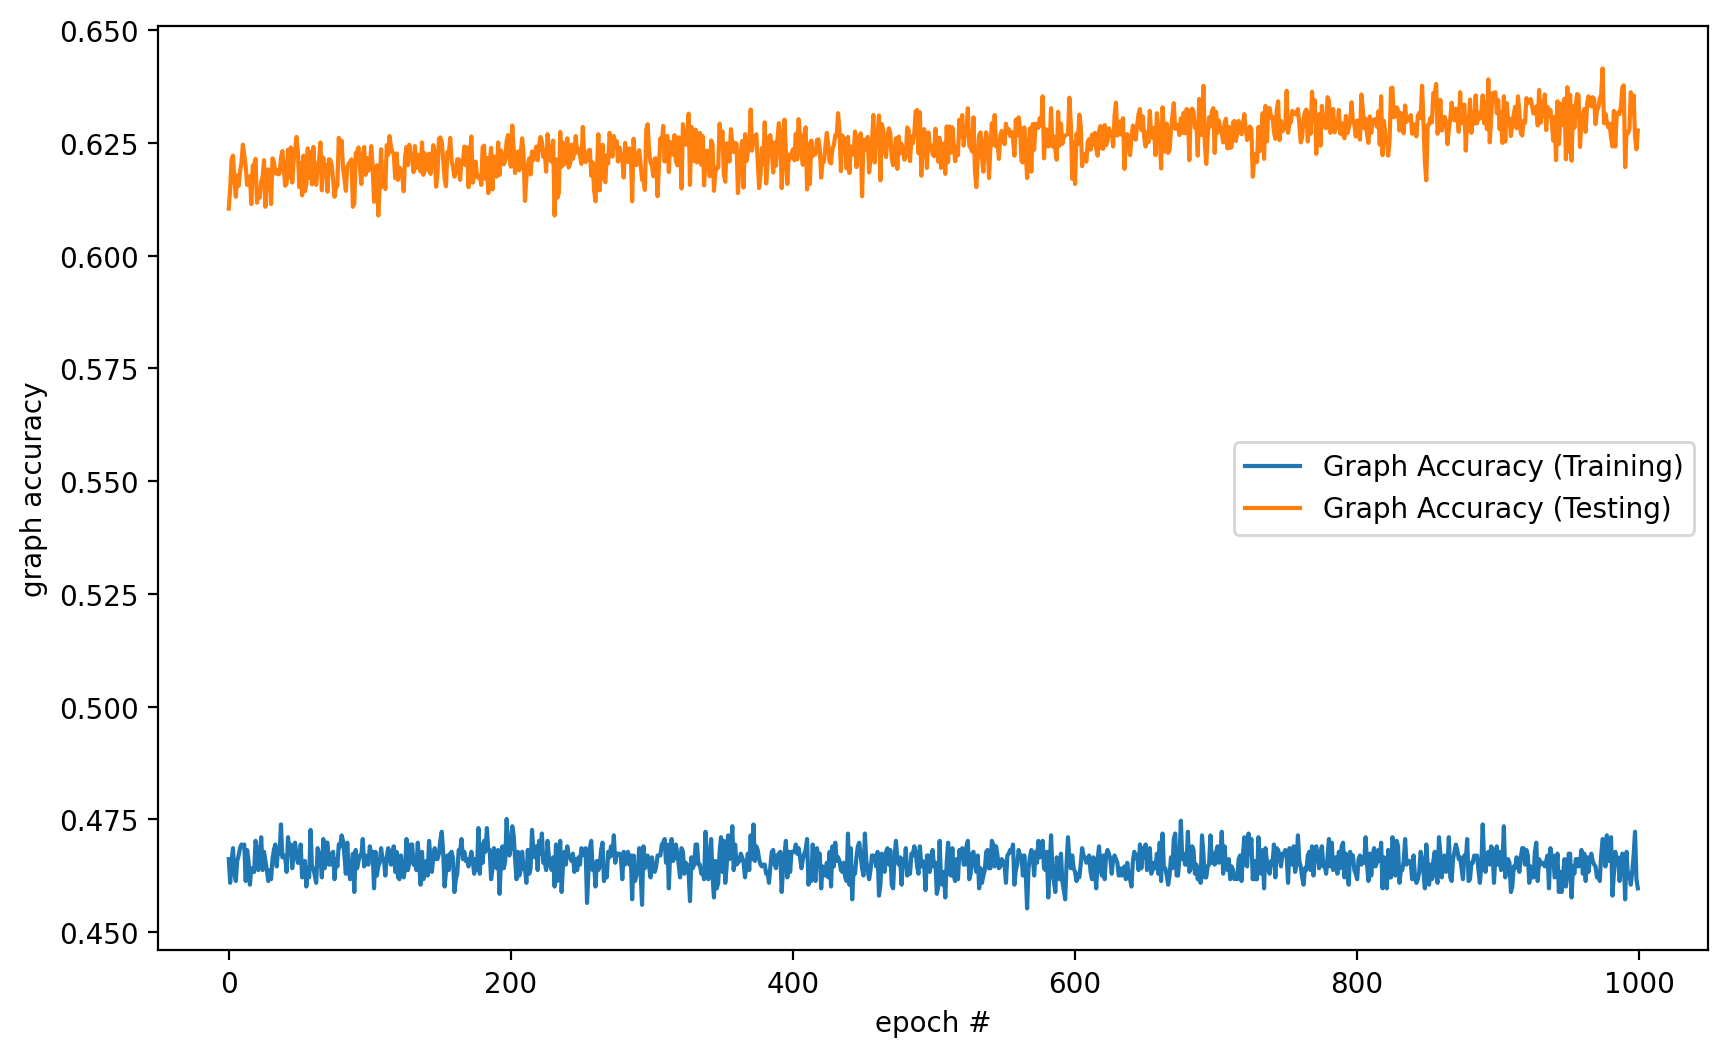

In [88]:
train(hcnet,optim.Adam(hcnet.parameters(), lr=.00001), nn.BCELoss(),trainloader,valloader, 1000,vala)
#torch.save(hcnet.state_dict(), 'hcnet5_unconnected_8_10000_16.pth')


model graph:
 [[1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Real Graph:
 [[1 0 0 1 1 0 1 1]
 [0 1 0 0 1 1 1 1]
 [0 0 1 0 0 1 0 0]
 [0 0 0 1 0 1 1 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]]
[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True False False  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True False  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]
model prediction Graph: [(0, 3), (0, 4), (0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 6), (3, 5), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


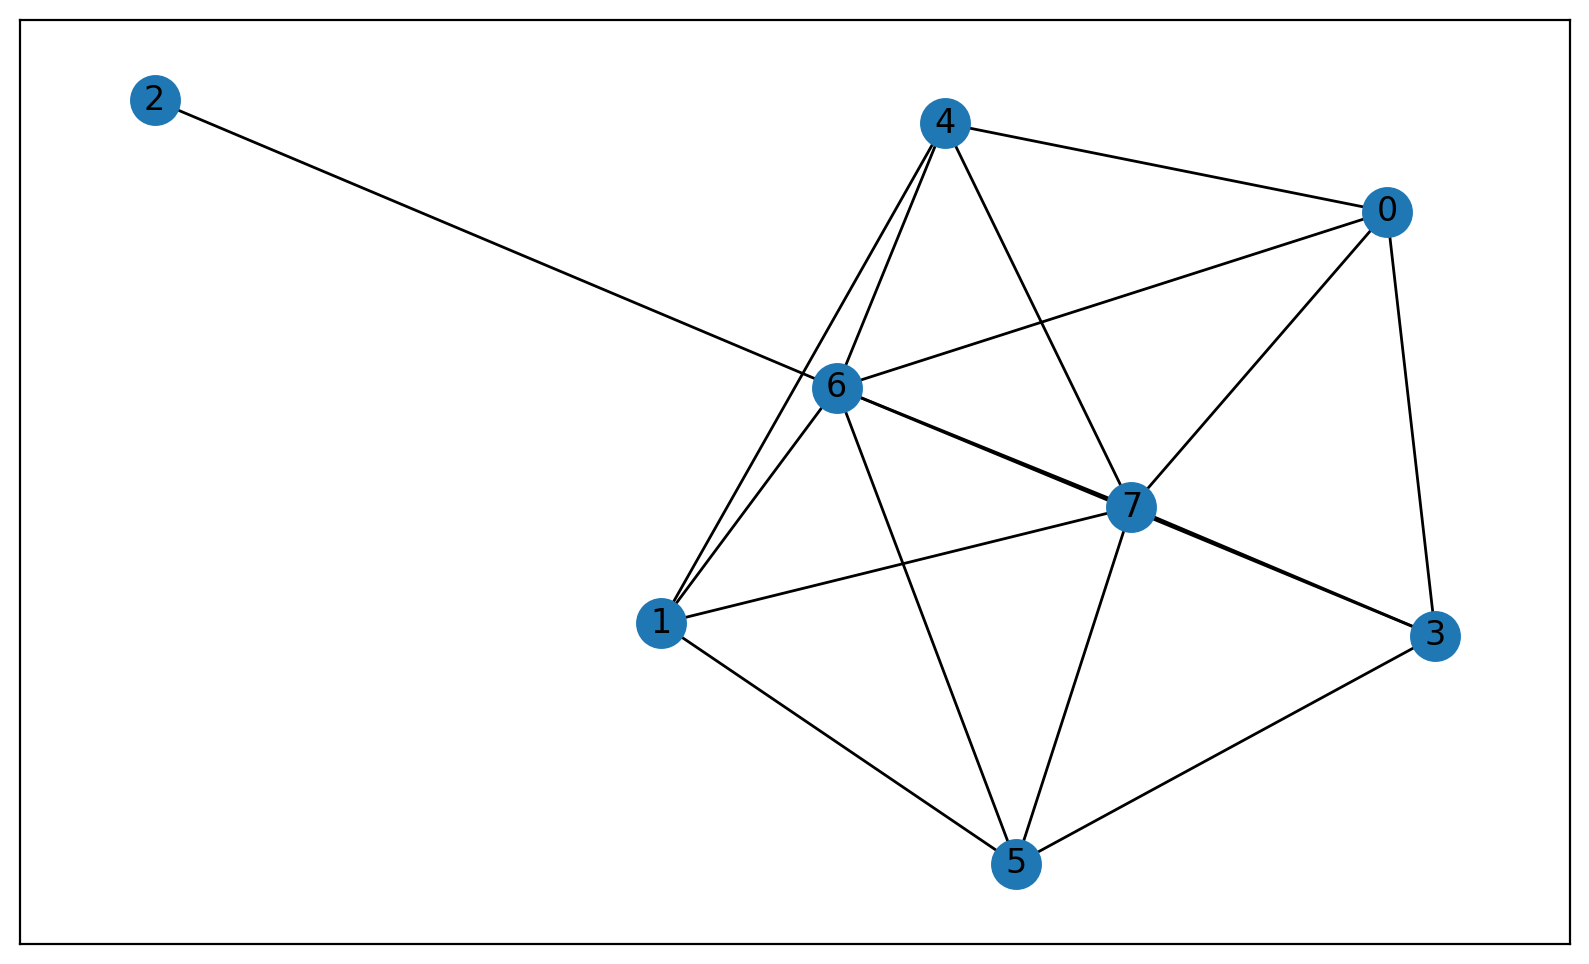

Real Graph: [(0, 3), (0, 4), (0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 5), (3, 5), (3, 6), (3, 7), (4, 6), (4, 7), (5, 7), (6, 7)]


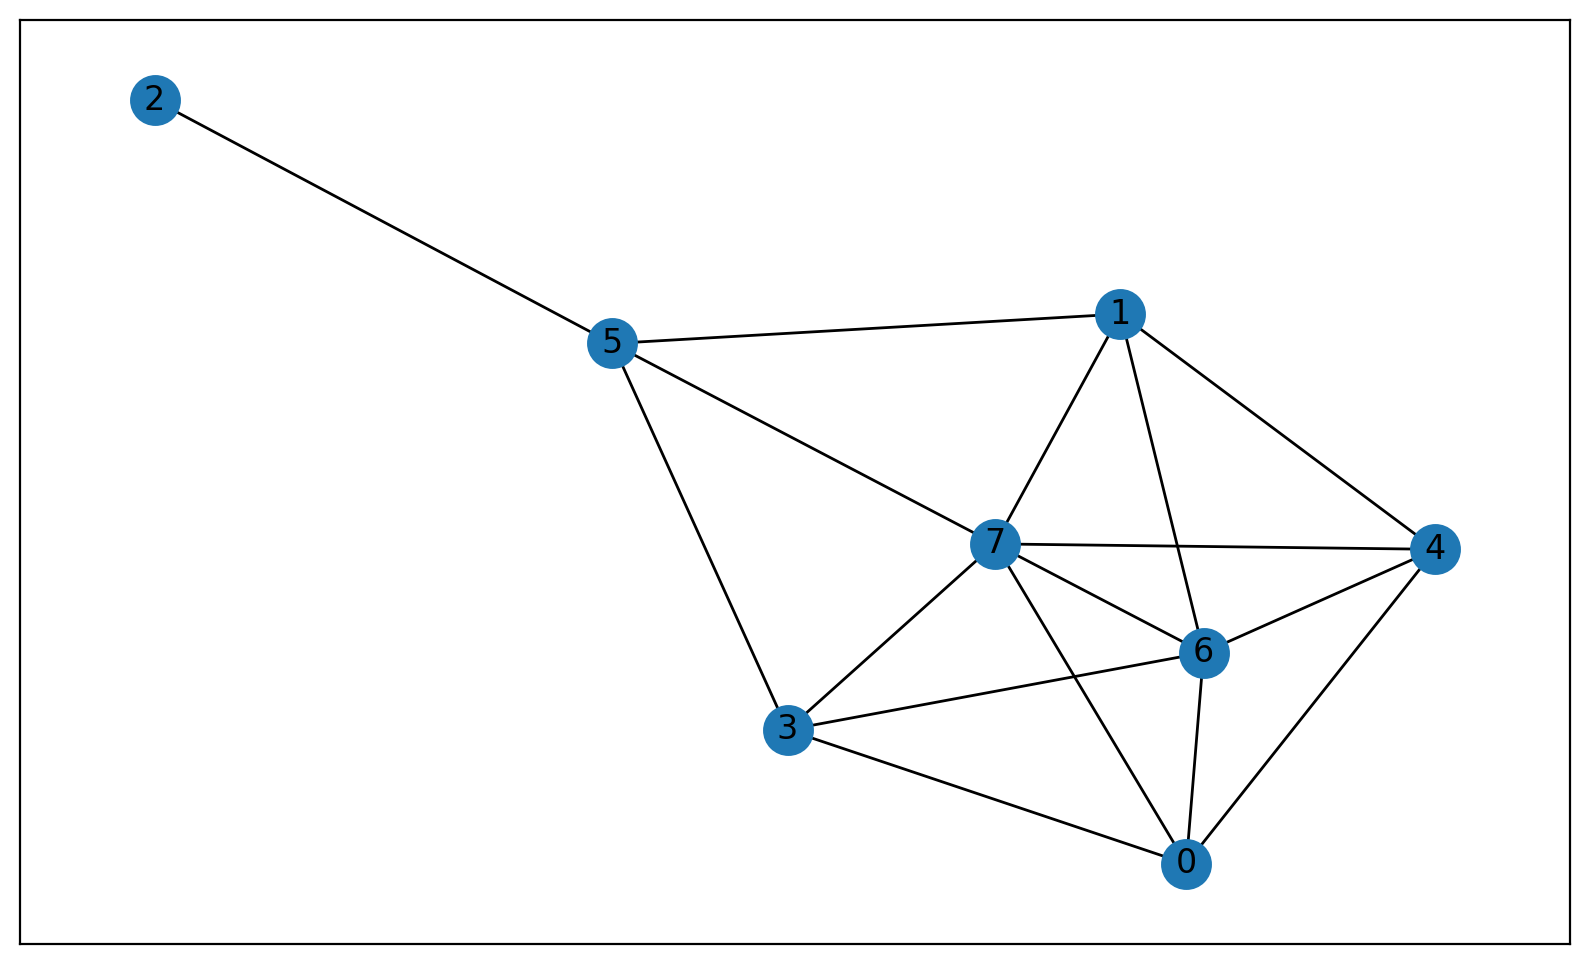

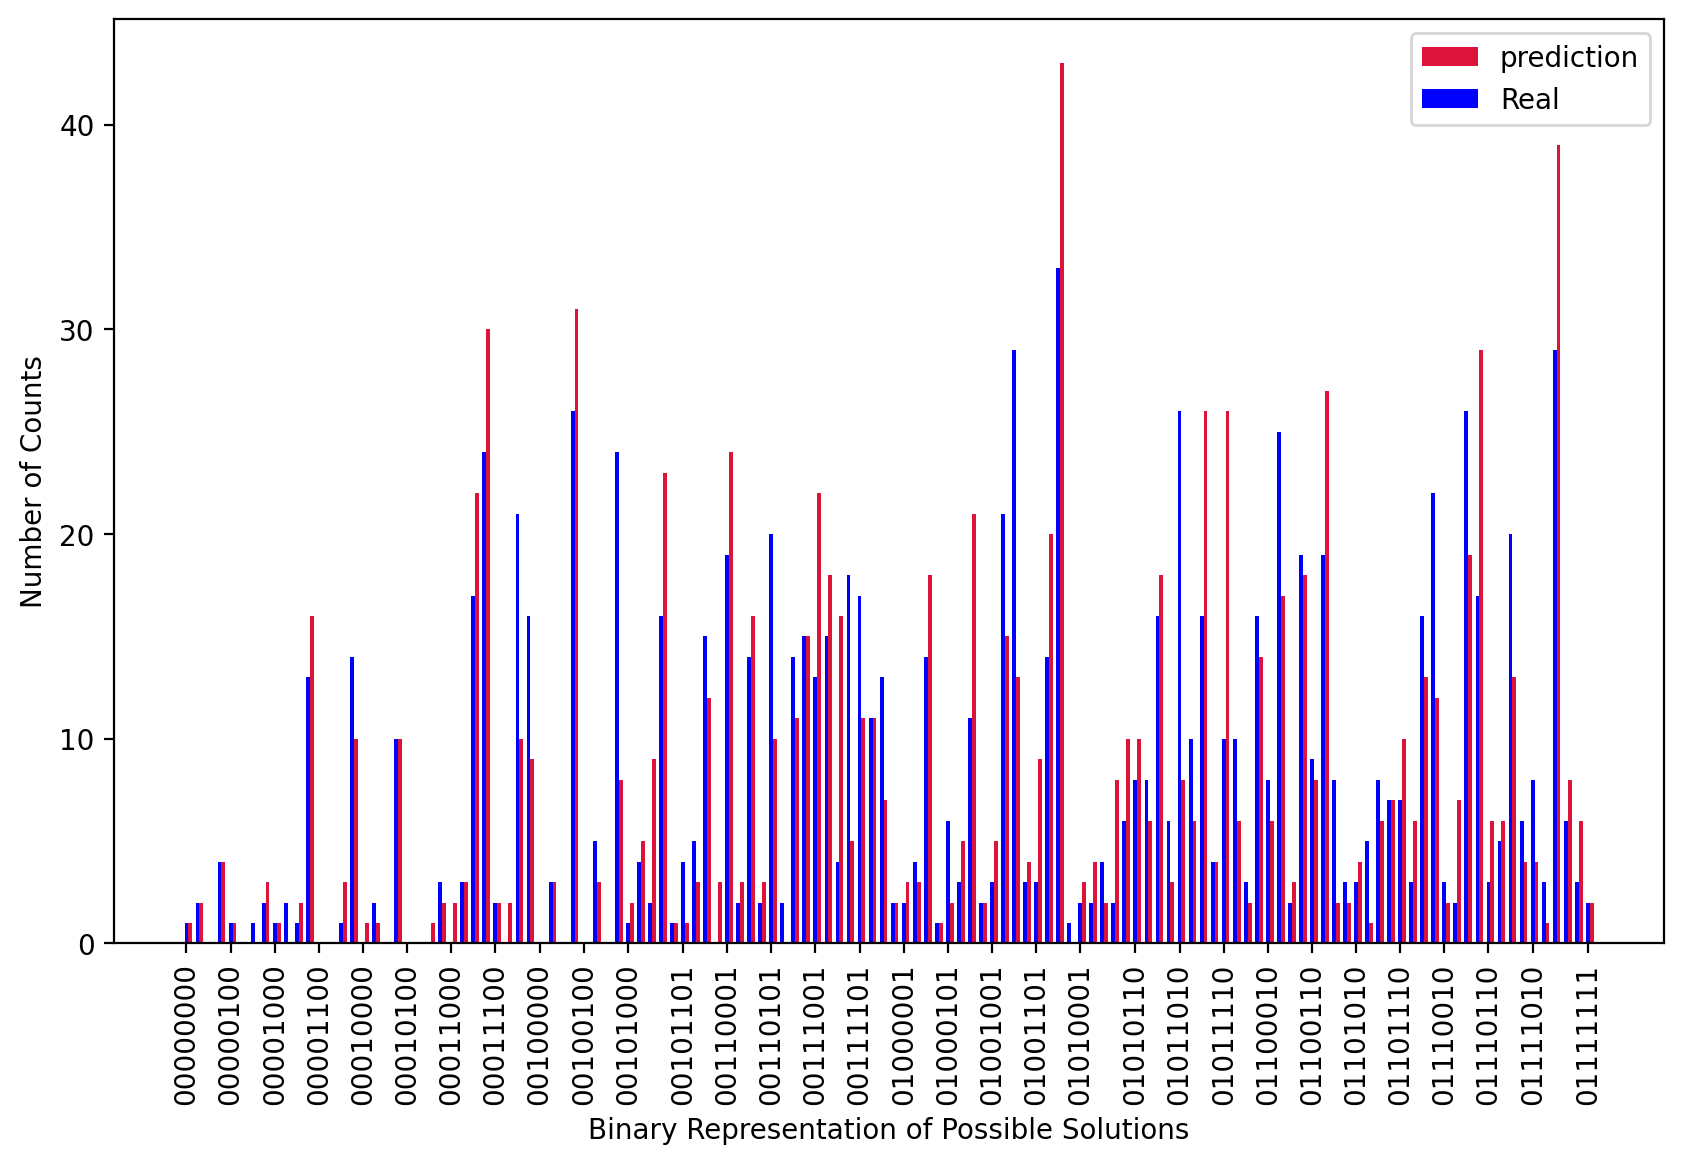

In [69]:
from qiskit.visualization import plot_histogram
G1 = testprint(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader,7)
# Extract the keys and values from G1[0] and G1[1] dictionaries
labels_0 = list(G1[0].keys())
values_0 = list(G1[0].values())

labels_1 = list(G1[1].keys())
values_1 = list(G1[1].values())

x_pos = np.arange(len(labels_0))
bar_width = 0.35
x_pos_shifted = x_pos + bar_width

# Create the bar plot
plt.bar(x_pos_shifted, values_0,width = bar_width, color='crimson', label='prediction')
plt.bar(labels_1, values_1, color='blue', width=bar_width, label='Real')

# Adjust the x-axis tick marks
desired_ticks = 32
indices = np.linspace(0, len(labels_0)-1, desired_ticks).astype(int)
plt.xticks(indices, [labels_0[i] for i in indices], rotation='vertical')
#plt.xticks(rotation='vertical')
#plt.tight_layout()  # Optionally, adjust the layout for better spacing

# Add legend, title, and other details
plt.legend()
plt.title('')
plt.xlabel('Binary Representation of Possible Solutions')
plt.ylabel('Number of Counts')

# Display the plot
plt.show()

accuracy for total elements: = 0.95,accuracy for graphs: = 0.39, number of graphs: = 2469.00
accuracy for total elements: = 0.95,accuracy for graphs: = 0.39, number of graphs: = 9877.00
{0.0: 957, 3.0: 207, 1.0: 197, 4.0: 211, 5.0: 208, 2.0: 150, 6.0: 169, 9.0: 52, 8.0: 106, 10.0: 55, 7.0: 122, 11.0: 16, 12.0: 8, 13.0: 7, 16.0: 1, 15.0: 1, 14.0: 2}


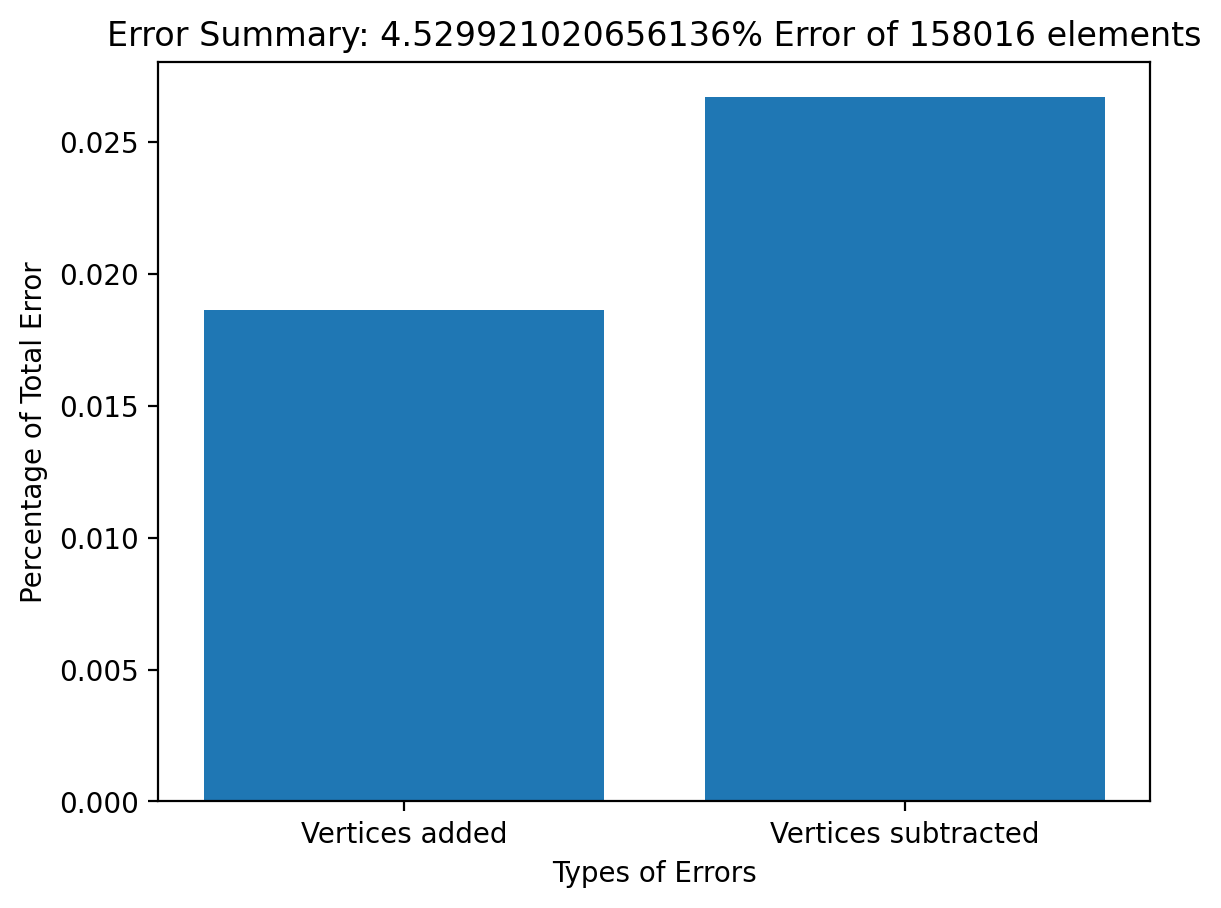

avg. subtracted: 2.789021164021164
avg. added: 1.94510582010582
avg. error per incorrect graph: 4.734126984126984


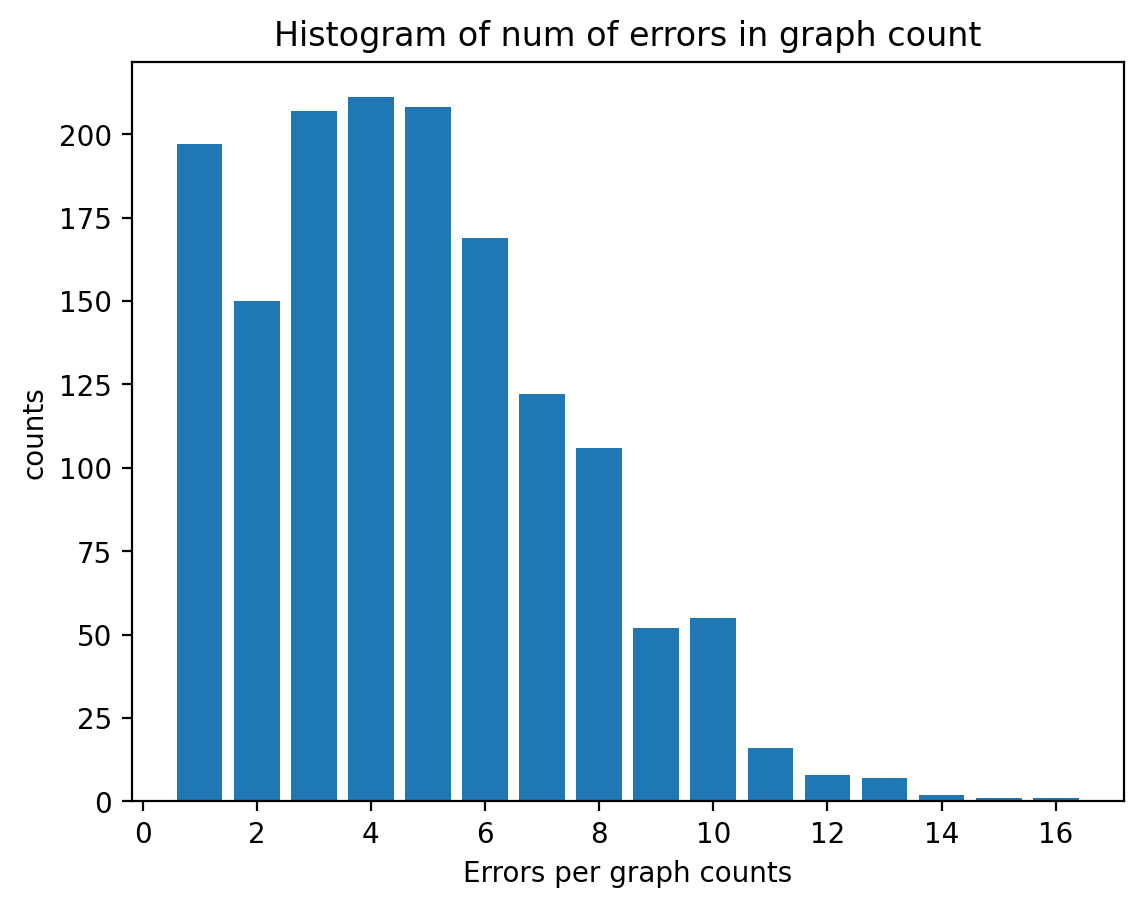

[[ 14.   0.  71. 274. 243. 270. 212. 193.]
 [  0.  18.   2. 192. 275. 221. 225. 205.]
 [  0.   0.  44.  15. 302. 305. 300. 308.]
 [  0.   0.   0.  57. 106. 335. 342. 269.]
 [  0.   0.   0.   0.  26. 338. 403. 300.]
 [  0.   0.   0.   0.   0.   5. 449. 307.]
 [  0.   0.   0.   0.   0.   0.  12. 506.]
 [  0.   0.   0.   0.   0.   0.   0.  14.]]


In [13]:
hcnet1 = HCNet(128, 64)
hcnet1.load_state_dict(torch.load('hcnet_unconnected_8_16384_16_3P.pth'))
test(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader,vala,False)
test(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), trainloader,traina,False)
data,data1,data3 =testhist(hcnet1,optim.Adam(hcnet1.parameters(), lr=0.001), nn.BCELoss(), valloader)
filtered_data = {k: v for k, v in data1.items() if k != 0.0}

# Separate the labels and values
labels = list(filtered_data.keys())
values = list(filtered_data.values())
print(data1)
# labels1 = data2.keys()
# labels1 = [str(x) for x in labels1]
# values1 = data2.values()
# Plot the data
plt.bar(["Vertices added","Vertices subtracted"], [data["total added"],data["total subtracted"]])

# Add labels and title
plt.xlabel('Types of Errors')
plt.ylabel('Percentage of Total Error')
plt.title(f'Error Summary: {data["Error"]*100}% Error of {data["total"]} elements')

# Display the plot
plt.show()
print("avg. subtracted:", data["avg. subtracted"])
print("avg. added:",data["avg. added"])
print("avg. error per incorrect graph:", data["avg. error"])

plt.bar(labels,values)

# Add labels and title
plt.xlabel('Errors per graph counts')
plt.ylabel('counts')
plt.title(f'Histogram of num of errors in graph count')

# Display the plot
plt.show()

# plt.bar(labels1,values1)
# plt.xticks(rotation='vertical')
# # Add labels and title
# plt.xlabel('Vertice errors')
# plt.ylabel('counts')
# plt.title(f'Histogram of num of errors for vertices')

# # Display the plot
# plt.show()
print(data3)